<a href="https://colab.research.google.com/github/mirianfsilva/machine-learning/blob/master/deep-learning/transferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<h1>CSE 6363-007: Machine Learning Group Project</h1> 
    <h2>Name: Ananthula, Vineeth Kumar. UTA ID: 1001953922 <br> Name: Wairagade, Sumedh. UTA ID: 1001966019 <br>Name: Vinnakota, Venkatesh. UTA ID: 1001876739 </h2>
</center>



# Transfer Learning
#### Implemented By Mírian Francielle (https://github.com/mirianfsilva/machine-learning-college-projects/blob/master/deep-learning/transferLearning.ipynb)

- Objectives: 
The goal of this practical is to practice the use of Convolutional Neural Networks (CNNs) and Transfer Learning. In this practical you will compare three strategies for training CNNs, two of which use Transfer Learning, in an image classification problem. 

- Task:
Train a CNN to classify the images from part A using the Keras API for TensorFlow. 

- Dataset:  CIFAR-101 . This dataset has 60000 images of 32x32 pixels, of which 50000 are for training and 10000 for test. Each image belongs to one of 10 classes, numbered from 0 to 9. The classes are: airplane, automobile, bird, cat, deer, dog, frog,
horse, ship and truck. 

- References: [The CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html)


In [ ]:
import matplotlib
import matplotlib as mpl
import matplotlib.style
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import keras

import matplotlib.pyplot as plt

from IPython.display import display
from IPython.display import Markdown

from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from keras import datasets
from keras import layers
from keras import optimizers
from keras import models
from keras.utils import to_categorical
from keras.models import Sequential
from keras.applications import VGG19
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

def printmd(s):
    display(Markdown(s))

In [ ]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


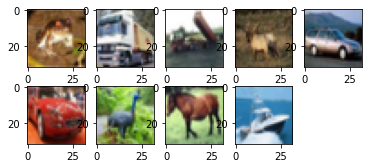

In [ ]:
for i in range(9):
	plt.subplot(351 + i)
	plt.imshow(x_train[i])
plt.show()


#### Dataset B: Classes 0 e 5  | Dataset A: Rest of Classes
Separation of data from A and B, into training and testing. 


In [ ]:
A, B = [], []

#Separating train data from A and B
B0 = list(filter(lambda x:x[1] in (0,5), enumerate(y_train)))
B0 = [idx[0] for idx in B0]
B0 = np.array(B0)

A0 = list(filter(lambda x:x[1] not in (0,5), enumerate(y_train)))
A0 = [idx[0] for idx in A0]
A0 = np.array(A0)

#Separating test data from A and B
B1 = list(filter(lambda x:x[1] in (0,5), enumerate(y_test)))
B1 = [idx[0] for idx in B1]
B1 = np.array(B1)

A1 = list(filter(lambda x:x[1] not in (0,5), enumerate(y_test)))
A1 = [idx[0] for idx in A1]
A1 = np.array(A1)

#===============================================

train_b0 = x_train[B0]
train_b1 = x_test[B1]
train_a0 = x_train[A0]
train_a1 = x_test[A1]

x_train_b = np.concatenate((train_b0, train_b1))
x_train_a = np.concatenate((train_a0, train_a1))


y_train_b0 = np.array(list(filter(lambda x:x in (0,5), y_train)))
y_train_b1 = np.array(list(filter(lambda x:x in (0,5), y_test)))
y_train_a0 = np.array(list(filter(lambda x:x not in (0,5), y_train)))
y_train_a1 = np.array(list(filter(lambda x:x not in (0,5), y_test)))

#After transforming the lists into arrays, concatenate the two arrays
y_train_a = np.concatenate((y_train_a0, y_train_a1))
y_train_b = np.concatenate((y_train_b0, y_train_b1))

print(x_train_a.shape,x_train_b.shape)
print(y_train_a.shape,y_train_b.shape)

(48000, 32, 32, 3) (12000, 32, 32, 3)
(48000, 1) (12000, 1)


### Data Processing

In [ ]:
# New target
y_train_a = np.reshape(y_train_a, len(y_train_a))
y_train_b = np.reshape(y_train_b, len(y_train_b))
print(y_train_a.shape)

# Normalization
x_train_a = x_train_a/255
x_train_b = x_train_b/255

# One-hot encoding of targets
y_train_a = pd.get_dummies(y_train_a).values
y_train_b = pd.get_dummies(y_train_b).values
print(x_train_a.shape,y_train_a.shape)

# Get the number of classes
n_classes_A = y_train_a.shape[1]
n_classes_B = y_train_b.shape[1]

(48000,)
(48000, 32, 32, 3) (48000, 8)


In [ ]:
x_train_A  = x_train_a[ :int(len (x_train_a)* 0.8)]
y_train_A  = y_train_a[ :int(len (y_train_a)* 0.8)]
print(x_train_A.shape,y_train_A.shape)

x_test_A  = x_train_a[ int(len (x_train_a)* 0.8):]
y_test_A  = y_train_a[ int(len (y_train_a)* 0.8):]

(38400, 32, 32, 3) (38400, 8)


In [ ]:
x_train_B  = x_train_b[:int(len(x_train_b)* 0.8)]
y_train_B  = y_train_b[:int(len(y_train_b)* 0.8)]

x_test_B  = x_train_b[int(len(x_train_b)* 0.8):]
y_test_B  = y_train_b[int(len(y_train_b)* 0.8):]

#### CNNs and models by era


In [ ]:
base_model_1 = VGG19(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=y_train.shape[1])

In [ ]:
weight_decay = 1e-4
strides = 1

model = Sequential()
model.add(base_model_1)
layer = Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train_A.shape[1:], strides=strides, kernel_initializer='he_normal')
model.add(layer)

model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), strides=strides, kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), padding="same"))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), strides=strides, kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), padding="same"))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(n_classes_A, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 conv2d (Conv2D)             (None, 1, 1, 64)          294976    
                                                                 
 batch_normalization (BatchN  (None, 1, 1, 64)         256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 1, 64)          36928     
                                                                 
 batch_normalization_1 (Batc  (None, 1, 1, 64)         256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 64)         0

In [ ]:
from keras import optimizers
# Initialize the optimized.
optimizer = keras.optimizers.Adam(learning_rate=0.001)

# Compiles the model, choosing the loss function and the main metric
model.compile(optimizer,loss='categorical_crossentropy', metrics=['accuracy'])

# model.summary()
print(x_train_A.shape,y_train_A.shape)
# Train for 20 epochs with mini-batches
history = model.fit(x_train_A, y_train_A, batch_size=128, epochs=20, verbose=1, validation_data=(x_test_A, y_test_A))

#testing
scores = model.evaluate(x_test_A, y_test_A, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))
  

(38400, 32, 32, 3) (38400, 8)
Epoch 1/20
300/300 [==============================] - 31s 74ms/step - loss: 1.6445 - accuracy: 0.2799 - val_loss: 2.4429 - val_accuracy: 0.1535
Epoch 2/20
300/300 [==============================] - 21s 70ms/step - loss: 1.3989 - accuracy: 0.4076 - val_loss: 1.4393 - val_accuracy: 0.3969
Epoch 3/20
300/300 [==============================] - 22s 74ms/step - loss: 1.2625 - accuracy: 0.4779 - val_loss: 1.8381 - val_accuracy: 0.2919
Epoch 4/20
300/300 [==============================] - 22s 73ms/step - loss: 1.1605 - accuracy: 0.5289 - val_loss: 2540292096.0000 - val_accuracy: 0.1254
Epoch 5/20
300/300 [==============================] - 23s 77ms/step - loss: 1.0907 - accuracy: 0.5609 - val_loss: 1.1829 - val_accuracy: 0.5590
Epoch 6/20
300/300 [==============================] - 23s 75ms/step - loss: 1.0231 - accuracy: 0.5912 - val_loss: 1.1178 - val_accuracy: 0.5484
Epoch 7/20
300/300 [==============================] - 22s 75ms/step - loss: 0.9716 - accuracy: 0.

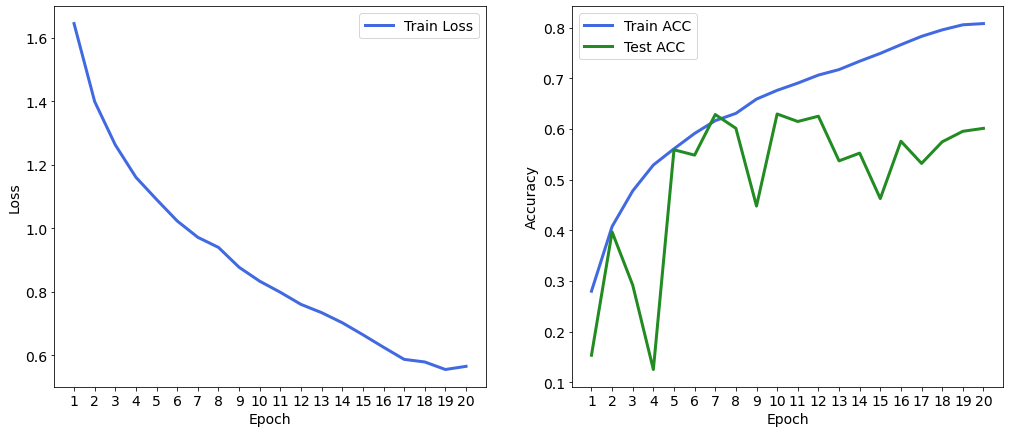

In [ ]:
# Generate graphs of training results
mpl.rc("font", **{"size": 14})
fig, axes = plt.subplots(1, 2, figsize=(17, 7))

# Loss
axes[0].plot(range(1, len(history.history["loss"])+1), history.history["loss"], label="Train Loss", color="royalblue", lw=3)
axes[0].set_ylabel("Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_xticks(range(1, len(history.history["loss"])+1))
axes[0].legend()

# Accuracy
axes[1].plot(range(1, len(history.history["accuracy"])+1), history.history["accuracy"], label="Train ACC", color="royalblue", lw=3)
axes[1].plot(range(1, len(history.history["val_accuracy"])+1), history.history["val_accuracy"], label="Test ACC", color="forestgreen", lw=3)
axes[1].set_ylabel("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_xticks(range(1, len(history.history["accuracy"])+1))
axes[1].legend()
plt.show()

### Training B - without transfer learning

In [ ]:
weight_decay = 1e-4
strides = 1
batch_size = 200

model2 = Sequential()
layer = Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train_B.shape[1:], strides=strides, kernel_initializer='he_normal')
model2.add(layer)

model2.add(BatchNormalization())

model2.add(Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), strides=strides, kernel_initializer='he_normal'))
model2.add(MaxPooling2D(pool_size=(2,2)))
 
model2.add(Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay), strides=strides, kernel_initializer='he_normal'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dense(n_classes_B, activation='softmax'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 64)        

In [ ]:
# Initializing optimizers.
optimizer = keras.optimizers.Adam(learning_rate=0.001)

# Compiles the model, choosing the loss function and the main metric
model2.compile(optimizer,loss='categorical_crossentropy', metrics=['accuracy'])

# Train for 20 epochs with mini-batches
history2 = model2.fit(x_train_B, y_train_B, batch_size=128, epochs=20, verbose=1, validation_data=(x_test_B, y_test_B))

#testing
scores = model2.evaluate(x_test_B, y_test_B, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

Epoch 1/20
75/75 [==============================] - 2s 22ms/step - loss: 0.8518 - accuracy: 0.8106 - val_loss: 0.4825 - val_accuracy: 0.8288
Epoch 2/20
75/75 [==============================] - 1s 17ms/step - loss: 0.2330 - accuracy: 0.9169 - val_loss: 0.3170 - val_accuracy: 0.9183
Epoch 3/20
75/75 [==============================] - 1s 17ms/step - loss: 0.1705 - accuracy: 0.9460 - val_loss: 0.2340 - val_accuracy: 0.9233
Epoch 4/20
75/75 [==============================] - 1s 17ms/step - loss: 0.1327 - accuracy: 0.9644 - val_loss: 0.3777 - val_accuracy: 0.8575
Epoch 5/20
75/75 [==============================] - 1s 18ms/step - loss: 0.1083 - accuracy: 0.9725 - val_loss: 0.2228 - val_accuracy: 0.9267
Epoch 6/20
75/75 [==============================] - 1s 18ms/step - loss: 0.0937 - accuracy: 0.9787 - val_loss: 0.1884 - val_accuracy: 0.9488
Epoch 7/20
75/75 [==============================] - 1s 18ms/step - loss: 0.0786 - accuracy: 0.9842 - val_loss: 0.1654 - val_accuracy: 0.9542
Epoch 8/20
75

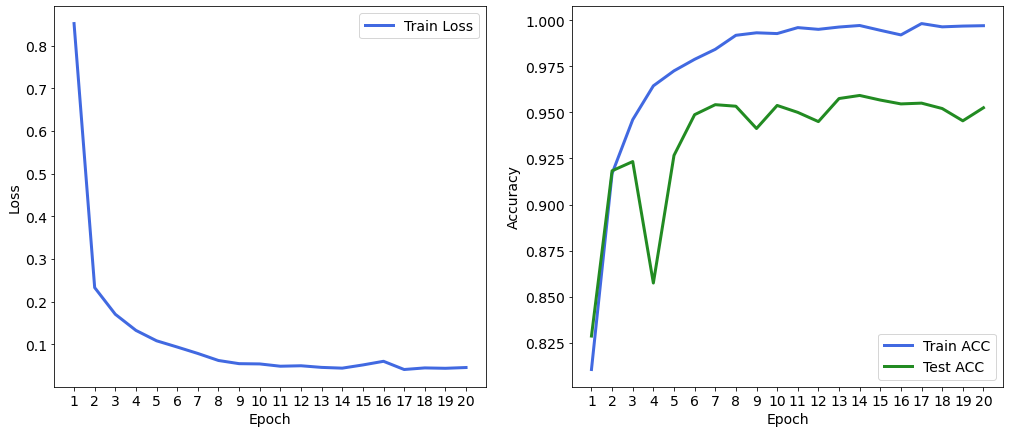

In [ ]:
# Generate graphs of training results
mpl.rc("font", **{"size": 14})
fig, axes = plt.subplots(1, 2, figsize=(17, 7))

# Loss
axes[0].plot(range(1, len(history2.history["loss"])+1), history2.history["loss"], label="Train Loss", color="royalblue", lw=3)
axes[0].set_ylabel("Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_xticks(range(1, len(history2.history["accuracy"])+1))
axes[0].legend()

# Accuracy
axes[1].plot(range(1, len(history2.history["accuracy"])+1), history2.history["accuracy"], label="Train ACC", color="royalblue", lw=3)
axes[1].plot(range(1, len(history2.history["val_accuracy"])+1), history2.history["val_accuracy"], label="Test ACC", color="forestgreen", lw=3)
axes[1].set_ylabel("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_xticks(range(1, len(history2.history["accuracy"])+1))
axes[1].legend()
plt.show()

#### We see that the accuracy of the second analysis, which contains classes 0 and 5, obtains better results than training the remaining classes.

#### Secondly, the confusion matrix of the predictions made in the tests with the best result, which is from class B with better definitions than the matrix with data from A. 


75/75 [==============================] - 1s 9ms/step


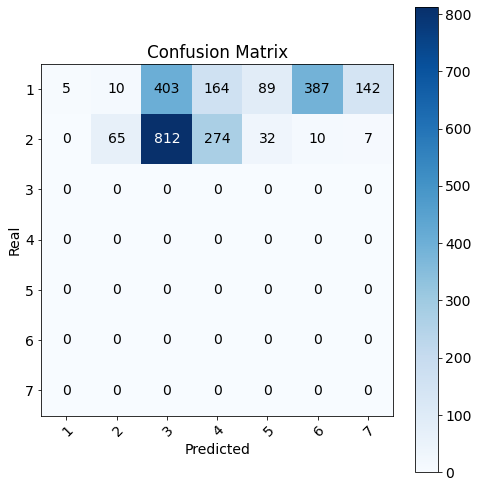

In [ ]:
# Confusion Matrix

# Predictions
y_proba = model.predict(x_test_B)
y_pred = np.argmax(y_proba, axis=1)

y_true = np.argmax(y_test_B, axis=1)

cm = metrics.confusion_matrix(y_true, y_pred)
classes = list(range(1, 11))
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=classes, yticklabels=classes, title="Confusion Matrix", ylabel="Real", xlabel="Predicted")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], "d"), ha="center", va="center", color="white" if cm[i, j] > cm.max()/2. else "black")
fig.tight_layout()
plt.show()

300/300 [==============================] - 3s 10ms/step


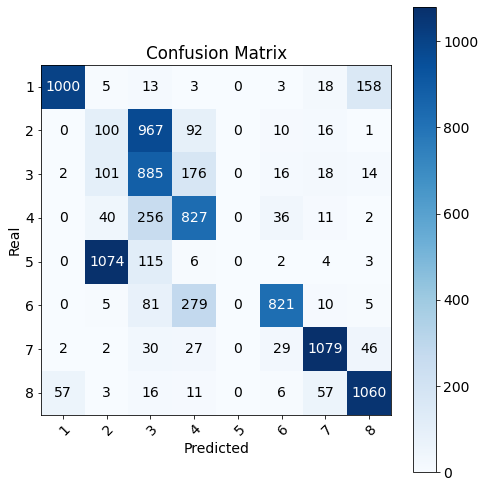

In [ ]:
# Confusion Matrix

# Predictions
y_proba = model.predict(x_test_A)
y_pred = np.argmax(y_proba, axis=1)

y_true = np.argmax(y_test_A, axis=1)

cm = metrics.confusion_matrix(y_true, y_pred)
classes = list(range(1, 11))
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=classes, yticklabels=classes, title="Confusion Matrix", ylabel="Real", xlabel="Predicted")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], "d"), ha="center", va="center", color="white" if cm[i, j] > cm.max()/2. else "black")
fig.tight_layout()
plt.show()